# wav with VAD, sample balance

In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neural_network
import xgboost
import matplotlib.pyplot as plt

In [2]:
csv_files = {'train':'train_vad_dur.csv', 'test':'test_vad_dur.csv'}

In [3]:
df_train = pd.read_csv(csv_files['train'])
df_train = df_train.drop(columns=['sound.files', 'duration'])
df_train.head(5)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.069760,0.092657,0.020465,0.005581,0.109767,0.104186,5.431045,39.811680,0.826134,0.418953,...,0.069760,0.172705,0.036117,0.202532,0.551758,0.304688,1.171875,0.867188,0.292149,child
1,0.107726,0.095311,0.099281,0.012353,0.190784,0.178431,5.473482,38.987176,0.929011,0.690661,...,0.107726,0.226449,0.136752,0.275862,0.813879,0.445312,1.281250,0.835938,0.377921,child
2,0.135659,0.080247,0.106821,0.076069,0.209326,0.133256,1.081528,3.508639,0.963765,0.764865,...,0.135659,0.181064,0.041344,0.266667,1.051432,0.414062,1.734375,1.320312,0.423669,child
3,0.208981,0.081661,0.241552,0.188060,0.268299,0.080239,3.414386,17.344207,0.886398,0.506294,...,0.208981,0.188685,0.126984,0.222222,0.471354,0.351562,0.757812,0.406250,0.399038,child
4,0.208771,0.072472,0.234876,0.186281,0.263802,0.077521,2.755505,11.134364,0.883219,0.503064,...,0.208771,0.162924,0.028881,0.190476,0.812500,0.585938,1.101562,0.515625,0.460606,child


In [4]:
df_train.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000,49461.000000
mean,0.195239,0.062463,0.207377,0.157637,0.243087,0.085450,2.365362,11.123738,0.890267,0.441962,0.207902,0.195239,0.174724,0.051242,0.255050,0.821785,0.202086,2.945274,2.743188,0.294343
std,0.030715,0.019248,0.040453,0.055262,0.023626,0.049358,1.159134,11.923276,0.045662,0.157107,0.082604,0.030715,0.031725,0.043249,0.029420,0.385657,0.136950,2.118841,2.131948,0.127017
min,0.034651,0.025627,0.002800,0.000743,0.025739,0.007125,-0.474661,1.307543,0.561900,0.070672,0.000000,0.034651,0.057017,0.015640,0.096386,0.080966,0.000000,0.117188,0.000000,0.000000
25%,0.180022,0.048038,0.187410,0.134694,0.231360,0.048178,1.640905,5.488872,0.862747,0.323549,0.185460,0.180022,0.152781,0.018913,0.246154,0.529948,0.125000,1.125000,0.898438,0.203987
50%,0.197093,0.059349,0.214587,0.163360,0.248381,0.073756,2.168738,8.068592,0.896193,0.432352,0.236923,0.197093,0.177531,0.030710,0.266667,0.747210,0.203125,2.015625,1.796875,0.273743
75%,0.216643,0.073189,0.235628,0.198140,0.259963,0.109088,2.821414,12.312397,0.923463,0.553561,0.266408,0.216643,0.197569,0.073394,0.275862,1.028460,0.265625,4.882812,4.695312,0.359859
max,0.264758,0.125319,0.275821,0.269231,0.279070,0.268800,15.360144,353.617204,0.992247,0.945851,0.280000,0.264758,0.273952,0.266667,0.275862,4.195312,1.929688,6.992188,6.992188,1.000000


In [5]:
df_test = pd.read_csv(csv_files['test'])
df_test = df_test.drop(columns=['sound.files', 'duration'])
df_test.head(5)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.225199,0.066435,0.249773,0.219545,0.267803,0.048258,2.927013,12.167927,0.858395,0.417524,...,0.225199,0.188293,0.031250,0.275862,1.004972,0.000000,5.718750,5.718750,0.144657,child
1,0.253216,0.038139,0.264252,0.249273,0.274239,0.024966,3.723604,18.817111,0.766713,0.150553,...,0.253216,0.208720,0.023155,0.275862,0.968359,0.000000,3.531250,3.531250,0.222287,child
2,0.205868,0.072096,0.233010,0.203945,0.249481,0.045536,3.074780,13.509514,0.866908,0.391388,...,0.205868,0.224472,0.128000,0.271186,0.897949,0.234375,4.851562,4.617188,0.180598,child
3,0.197341,0.064822,0.224982,0.176351,0.237263,0.060912,3.740208,19.817440,0.895382,0.497791,...,0.197341,0.197281,0.057971,0.250000,1.431250,0.453125,6.484375,6.031250,0.284974,child
4,0.205682,0.060251,0.228571,0.200000,0.236923,0.036923,4.294896,25.418551,0.869554,0.438868,...,0.205682,0.206830,0.102564,0.250000,0.791360,0.242188,3.203125,2.960938,0.164248,child


In [6]:
df_test.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000
mean,0.198011,0.061846,0.211076,0.162453,0.244968,0.082515,2.350410,10.697890,0.889259,0.437126,0.217268,0.198011,0.171216,0.049874,0.254630,0.872726,0.194437,3.217821,3.023384,0.285993
std,0.028551,0.017541,0.037442,0.050869,0.021910,0.044742,1.077632,9.622467,0.047233,0.154822,0.074236,0.028551,0.035058,0.043207,0.030622,0.403240,0.145800,2.123991,2.145305,0.126298
min,0.045151,0.024762,0.009800,0.001400,0.042768,0.010566,-0.020291,1.579513,0.651948,0.069069,0.000000,0.045151,0.068796,0.015640,0.105263,0.151562,0.000000,0.226562,0.007812,0.026693
25%,0.183701,0.049402,0.193209,0.137736,0.233966,0.047842,1.641872,5.537343,0.860396,0.324347,0.201372,0.183701,0.144978,0.018713,0.246154,0.575738,0.093750,1.289062,1.062500,0.196352
50%,0.199188,0.059760,0.217205,0.164656,0.249210,0.074971,2.195897,8.196030,0.897043,0.428632,0.241870,0.199188,0.175387,0.029602,0.266667,0.798580,0.203125,2.484375,2.339844,0.266260
75%,0.216971,0.071382,0.236843,0.200198,0.260584,0.107547,2.865401,12.591321,0.923610,0.541976,0.267421,0.216971,0.196593,0.069565,0.275862,1.087002,0.265625,5.250000,5.078125,0.348870
max,0.257785,0.119511,0.274595,0.264151,0.277838,0.262754,9.781275,161.707601,0.983677,0.927131,0.280000,0.257785,0.261002,0.253968,0.275862,3.832031,2.007812,6.992188,6.992188,1.000000


In [7]:
# select samples
len_child = len(df_train.loc[df_train['label']=='child']) # 10447
len_male = len(df_train.loc[df_train['label']=='male']) # 15532
len_female = len(df_train.loc[df_train['label']=='female']) # 23452

n = min(len_child, len_male, len_female) # shortest label

train_c = df_train.loc[df_train['label']=='child'].reset_index().iloc[0:n]
train_m = df_train.loc[df_train['label']=='male'].reset_index().iloc[0:n]
train_f = df_train.loc[df_train['label']=='female'].reset_index().iloc[0:n]

df_train = pd.concat([train_c, train_m, train_f])
df_train = df_train.drop(['index'], 1)

In [8]:
df_train.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000,31431.000000
mean,0.191521,0.065213,0.203442,0.150372,0.242297,0.091924,2.447249,12.125733,0.893404,0.459696,0.201289,0.191521,0.174329,0.050426,0.255713,0.845759,0.208442,3.000964,2.792522,0.290424
std,0.033730,0.020059,0.045522,0.060116,0.026003,0.053024,1.281645,13.984973,0.046375,0.160836,0.090984,0.033730,0.030636,0.042187,0.029066,0.384526,0.139311,2.118644,2.131645,0.124101
min,0.034651,0.026519,0.002800,0.000743,0.025739,0.007125,-0.443512,1.462045,0.561900,0.070672,0.000000,0.034651,0.057017,0.015640,0.105263,0.080966,0.000000,0.117188,0.000000,0.000000
25%,0.176089,0.050249,0.182785,0.127194,0.230158,0.050700,1.648105,5.558245,0.865845,0.339477,0.174810,0.176089,0.153574,0.018868,0.246154,0.554810,0.125000,1.179688,0.953125,0.202592
50%,0.194041,0.061514,0.211613,0.156764,0.248712,0.081882,2.212844,8.372116,0.900097,0.451991,0.237146,0.194041,0.176679,0.030132,0.266667,0.777344,0.210938,2.101562,1.859375,0.270336
75%,0.214923,0.078143,0.235719,0.194988,0.260553,0.114872,2.921187,13.118743,0.926990,0.575651,0.268414,0.214923,0.195757,0.072727,0.275862,1.057080,0.273438,4.960938,4.757812,0.354315
max,0.264758,0.125319,0.275821,0.268601,0.279070,0.268800,15.360144,353.617204,0.992247,0.945851,0.280000,0.264758,0.273952,0.266667,0.275862,3.562500,1.835938,6.992188,6.992188,1.000000


In [9]:
len_childt = len(df_test.loc[df_test['label']=='child']) # 
len_malet = len(df_test.loc[df_test['label']=='male']) # 
len_femalet = len(df_test.loc[df_test['label']=='female']) # 

n = min(len_childt, len_malet, len_femalet) # shortest label

test_c = df_test.loc[df_test['label']=='child'].reset_index().iloc[0:n]
test_m = df_test.loc[df_test['label']=='male'].reset_index().iloc[0:n]
test_f = df_test.loc[df_test['label']=='female'].reset_index().iloc[0:n]

df_test = pd.concat([test_c, test_m, test_f])
df_test = df_test.drop(['index'], 1)

In [10]:
df_test.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000
mean,0.197988,0.061860,0.211055,0.162414,0.244959,0.082545,2.349867,10.694870,0.889287,0.437229,0.217237,0.197988,0.171188,0.049885,0.254618,0.872987,0.194501,3.218191,3.023690,0.286077
std,0.028553,0.017542,0.037452,0.050878,0.021915,0.044753,1.077271,9.621169,0.047225,0.154820,0.074263,0.028553,0.035059,0.043226,0.030634,0.403318,0.145834,2.123822,2.145089,0.126324
min,0.045151,0.024762,0.009800,0.001400,0.042768,0.010566,-0.020291,1.579513,0.651948,0.069069,0.000000,0.045151,0.068796,0.015640,0.105263,0.151562,0.000000,0.226562,0.007812,0.026693
25%,0.183680,0.049449,0.193200,0.137735,0.233964,0.047863,1.641846,5.536326,0.860548,0.324419,0.201348,0.183680,0.144926,0.018713,0.246154,0.575521,0.093750,1.289062,1.062500,0.196878
50%,0.199164,0.059769,0.217171,0.164552,0.249204,0.075024,2.195140,8.195979,0.897059,0.428688,0.241798,0.199164,0.175377,0.029575,0.266667,0.798780,0.203125,2.484375,2.343750,0.266379
75%,0.216968,0.071418,0.236840,0.200191,0.260564,0.107579,2.865697,12.592526,0.923611,0.542088,0.267411,0.216968,0.196571,0.069565,0.275862,1.087402,0.265625,5.250000,5.078125,0.349057
max,0.257785,0.119511,0.274595,0.264151,0.277838,0.262754,9.781275,161.707601,0.983677,0.927131,0.280000,0.257785,0.261002,0.253968,0.275862,3.832031,2.007812,6.992188,6.992188,1.000000


In [11]:
# Preprocessing: label encoder and normalization
from sklearn import preprocessing
df_train = df_train.replace({'child':0, 'male':1,'female':2})
df_test = df_test.replace({'child':0, 'male':1,'female':2})

X_train = df_train.drop(['label'], 1)
y_train = df_train['label']

X_test = df_test.drop(['label'], 1)
y_test = df_test['label']

X_train[:]=preprocessing.MinMaxScaler().fit_transform(X_train)
X_test[:]=preprocessing.MinMaxScaler().fit_transform(X_test)
X_train.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.152580,0.669410,0.064702,0.018064,0.331694,0.370923,0.371721,0.108900,0.614002,0.397954,0.000000,0.152580,0.533282,0.081574,0.570159,0.135225,0.165957,0.153409,0.124022,0.292149
1,0.317570,0.696276,0.353383,0.043345,0.651501,0.654654,0.374407,0.106559,0.853059,0.708414,0.000000,0.317570,0.781026,0.482467,1.000000,0.210514,0.242553,0.169318,0.119553,0.377921
2,0.438960,0.543804,0.380999,0.281219,0.724691,0.482016,0.096499,0.005812,0.933816,0.793201,0.955684,0.438960,0.571814,0.102393,0.946099,0.278747,0.225532,0.235227,0.188827,0.423669
3,0.757605,0.558121,0.874483,0.699315,0.957481,0.279408,0.244114,0.045100,0.754039,0.497751,0.997015,0.757605,0.606944,0.443554,0.685579,0.112131,0.191489,0.093182,0.058101,0.399038
4,0.756692,0.465113,0.850030,0.692675,0.939730,0.269020,0.202423,0.027466,0.746651,0.494061,0.958678,0.756692,0.488195,0.052746,0.499493,0.210118,0.319149,0.143182,0.073743,0.460606


In [12]:
X_test.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.846753,0.439821,0.906260,0.830237,0.957311,0.149458,0.300697,0.066125,0.622336,0.406095,0.971591,0.846753,0.621710,0.065497,1.000000,0.231875,0.000000,0.811778,0.817673,0.121199
1,0.978512,0.141186,0.960943,0.943376,0.984689,0.057099,0.381969,0.107649,0.345961,0.094963,0.979424,0.978512,0.727986,0.031530,1.000000,0.221927,0.000000,0.488453,0.504474,0.200958
2,0.755841,0.499573,0.842957,0.770862,0.879368,0.138668,0.315773,0.074503,0.647998,0.375635,0.835640,0.755841,0.809940,0.471450,0.972593,0.202797,0.116732,0.683603,0.659955,0.158126
3,0.715739,0.422793,0.812639,0.665843,0.827393,0.199638,0.383663,0.113896,0.733835,0.499639,0.836842,0.715739,0.668474,0.177615,0.848404,0.347697,0.225681,0.924942,0.862416,0.265365
4,0.754964,0.374551,0.826193,0.755849,0.825946,0.104514,0.440255,0.148875,0.655976,0.430970,0.835165,0.754964,0.718154,0.364724,0.848404,0.173836,0.120623,0.439954,0.422819,0.141328


In [13]:
# Name of the columns
col_names = list(df_train.columns.values)
print(col_names)
print (type(df_train.columns.values))

['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label']
<class 'numpy.ndarray'>


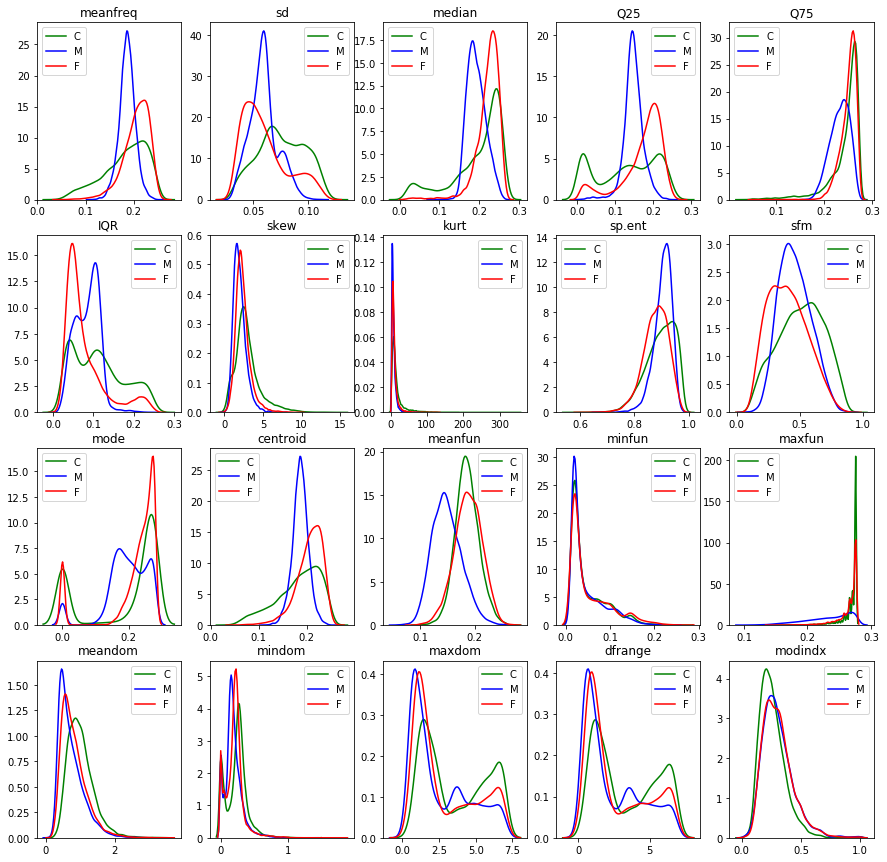

In [14]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(4,5,figsize=(15,15))
for i in range(1,21):
    plt.subplot(4,5,i)
    plt.title(df_train.columns[i-1])
    sns.kdeplot(df_train.loc[df_train['label'] == 0, df_train.columns[i-1]], color= 'green', label='C')
    sns.kdeplot(df_train.loc[df_train['label'] == 1, df_train.columns[i-1]], color= 'blue', label='M')
    sns.kdeplot(df_train.loc[df_train['label'] == 2, df_train.columns[i-1]], color= 'red', label='F')

In [15]:
# At first glance, most significant features are Q25, IQR and meanfun. 

x_train3 = df_train[["meanfun","IQR","Q25"]]
y_train3 = df_train["label"]
x_test3 = df_test[["meanfun","IQR","Q25"]]
y_test3 = df_test["label"]

In [16]:
def plot_cm(y_true, y_pred, desc = None):
    labels = ["child", "male", "female"]
    
    labeld = {0:'child', 1:'male', 2:'female'}
    y_true = [labeld[i] for i in y_true]
    y_pred = [labeld[i] for i in y_pred]

    mat = confusion_matrix(y_true, y_pred, labels=labels)
    accuracy = accuracy_score(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=labels,
                yticklabels=labels)
    if desc != None:
        plt.title('{}:{}'.format(desc, accuracy))
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()

In [17]:
#Producing X and y
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train3 = np.array(x_train3)
y_train3 = np.array(y_train3)

X_test3 = np.array(x_test3)
y_test3 = np.array(y_test3)

In [18]:
def classify(model,x_train,y_train,x_test,y_test, desc):
    from sklearn.metrics import classification_report
    target_names = ["child", "female", "male"]
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    
    plot_cm(y_test, y_pred, desc = desc)
    accuracy = model.score(x_test, y_test)
    print('Accuracy='+str(accuracy))
    
    print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

In [19]:
# K-Nearest Neighbors
def knn_error(k,x_train,y_train,x_test,y_test):
    error_rate = []
    K=range(1,k)
    for i in K:
        knn = neighbors.KNeighborsClassifier(n_neighbors = i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    kloc = error_rate.index(min(error_rate))
    print("Lowest error is %s occurs at k=%s." % (error_rate[kloc], K[kloc]))

    plt.plot(K, error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()
    return K[kloc]

Lowest error is 0.28851727982162767 occurs at k=14.


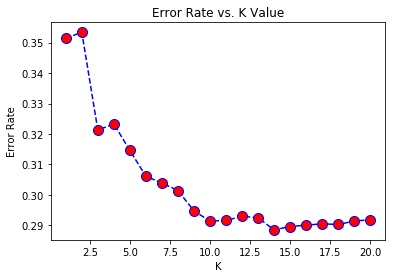

In [20]:
k=knn_error(21,X_train,y_train,X_test,y_test)

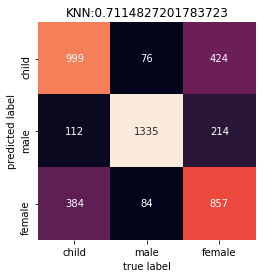

Accuracy=0.7114827201783723
              precision    recall  f1-score   support

       child     0.6664    0.6682    0.6673      1495
      female     0.8037    0.8930    0.8460      1495
        male     0.6468    0.5732    0.6078      1495

   micro avg     0.7115    0.7115    0.7115      4485
   macro avg     0.7057    0.7115    0.7070      4485
weighted avg     0.7057    0.7115    0.7070      4485



In [21]:
model = neighbors.KNeighborsClassifier(n_neighbors = k)
classify(model,X_train,y_train,X_test,y_test, desc = 'KNN')

Lowest error is 0.3331103678929766 occurs at k=18.


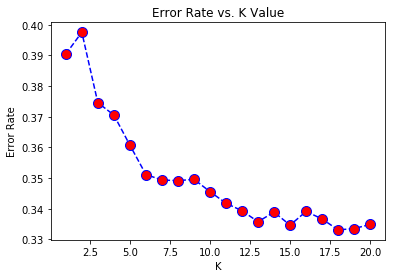

In [22]:
k=knn_error(21,X_train3,y_train3,X_test3,y_test3)

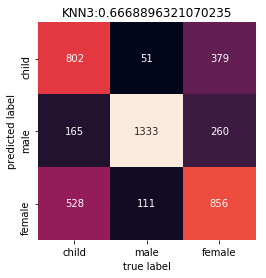

Accuracy=0.6668896321070235
              precision    recall  f1-score   support

       child     0.6510    0.5365    0.5882      1495
      female     0.7582    0.8916    0.8196      1495
        male     0.5726    0.5726    0.5726      1495

   micro avg     0.6669    0.6669    0.6669      4485
   macro avg     0.6606    0.6669    0.6601      4485
weighted avg     0.6606    0.6669    0.6601      4485



In [23]:
model = neighbors.KNeighborsClassifier(n_neighbors = k)
classify(model,X_train3,y_train3,X_test3,y_test3, desc = 'KNN3')

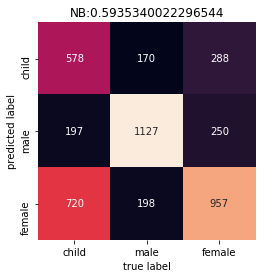

Accuracy=0.5935340022296544
              precision    recall  f1-score   support

       child     0.5579    0.3866    0.4567      1495
      female     0.7160    0.7538    0.7344      1495
        male     0.5104    0.6401    0.5680      1495

   micro avg     0.5935    0.5935    0.5935      4485
   macro avg     0.5948    0.5935    0.5864      4485
weighted avg     0.5948    0.5935    0.5864      4485



In [24]:
# Naive Bayes
model=naive_bayes.GaussianNB()
classify(model,X_train,y_train,X_test,y_test, desc = "NB")

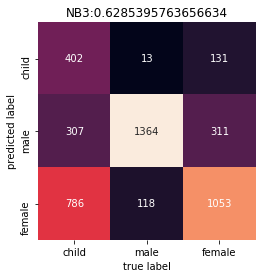

Accuracy=0.6285395763656634
              precision    recall  f1-score   support

       child     0.7363    0.2689    0.3939      1495
      female     0.6882    0.9124    0.7846      1495
        male     0.5381    0.7043    0.6101      1495

   micro avg     0.6285    0.6285    0.6285      4485
   macro avg     0.6542    0.6285    0.5962      4485
weighted avg     0.6542    0.6285    0.5962      4485



In [25]:
model=naive_bayes.GaussianNB()
classify(model,X_train3,y_train3,X_test3,y_test3, desc = "NB3")

In [26]:
# Decision Tree
#Find the best parameter to prune the tree
def dt_error(n,x_train,y_train,x_test,y_test):
    nodes = range(2, n)
    error_rate = []
    for k in nodes:
        model = tree.DecisionTreeClassifier(max_leaf_nodes=k)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    kloc = error_rate.index(min(error_rate))
    print("Lowest error is %s occurs at n=%s." % (error_rate[kloc], nodes[kloc]))
    plt.plot(nodes, error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.xlabel('Tree Size')
    plt.ylabel('Cross-Validated MSE')
    plt.show()
    return nodes[kloc]

Lowest error is 0.34225195094760313 occurs at n=3.


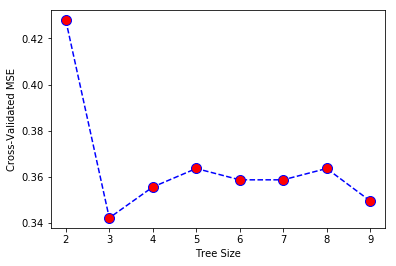

In [27]:
n=dt_error(10,X_train,y_train,X_test,y_test)

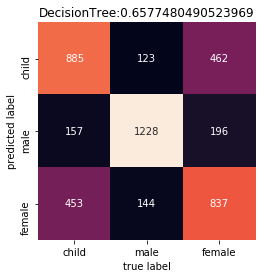

Accuracy=0.6577480490523969
              precision    recall  f1-score   support

       child     0.6020    0.5920    0.5970      1495
      female     0.7767    0.8214    0.7984      1495
        male     0.5837    0.5599    0.5715      1495

   micro avg     0.6577    0.6577    0.6577      4485
   macro avg     0.6541    0.6577    0.6556      4485
weighted avg     0.6541    0.6577    0.6556      4485



In [28]:
#prune tree
pruned_tree = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
classify(pruned_tree,X_train,y_train,X_test,y_test, desc = 'DecisionTree')

Lowest error is 0.33690078037904125 occurs at n=13.


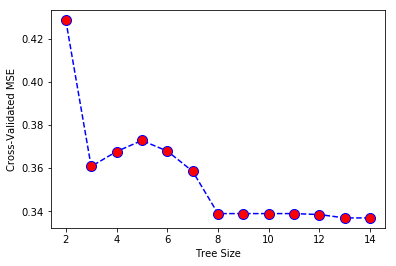

In [29]:
n=dt_error(15,X_train3,y_train3,X_test3,y_test3)

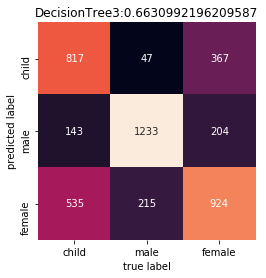

Accuracy=0.6630992196209587
              precision    recall  f1-score   support

       child     0.6637    0.5465    0.5994      1495
      female     0.7804    0.8247    0.8020      1495
        male     0.5520    0.6181    0.5831      1495

   micro avg     0.6631    0.6631    0.6631      4485
   macro avg     0.6653    0.6631    0.6615      4485
weighted avg     0.6653    0.6631    0.6615      4485



In [30]:
pruned_tree = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
classify(pruned_tree,X_train3,y_train3,X_test3,y_test3, desc = 'DecisionTree3')

In [31]:
# Random Forest
def rf_error(n,x_train,y_train,x_test,y_test):
    error_rate = []
    e=range(1,n,20)
    for i in e:
        model = ensemble.RandomForestClassifier(n_estimators = i)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    nloc = error_rate.index(min(error_rate))
    print("Lowest error is %s occurs at n=%s." % (error_rate[nloc], e[nloc]))

    plt.plot(e, error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. n Value')
    plt.xlabel('n')
    plt.ylabel('Error Rate')
    plt.show()
    return e[nloc]

Lowest error is 0.2798216276477146 occurs at n=81.


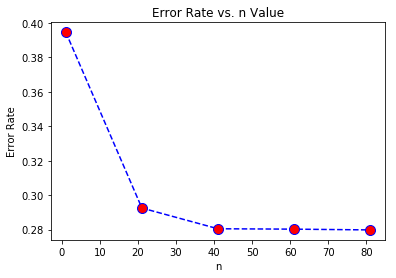

In [32]:
e=rf_error(100,X_train,y_train,X_test,y_test)

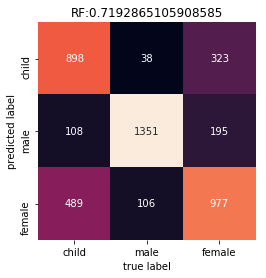

Accuracy=0.7192865105908585
              precision    recall  f1-score   support

       child     0.7133    0.6007    0.6521      1495
      female     0.8168    0.9037    0.8581      1495
        male     0.6215    0.6535    0.6371      1495

   micro avg     0.7193    0.7193    0.7193      4485
   macro avg     0.7172    0.7193    0.7158      4485
weighted avg     0.7172    0.7193    0.7158      4485



In [33]:
model=ensemble.RandomForestClassifier(n_estimators = e)
classify(model,X_train,y_train,X_test,y_test,desc="RF")

Lowest error is 0.3331103678929766 occurs at n=81.


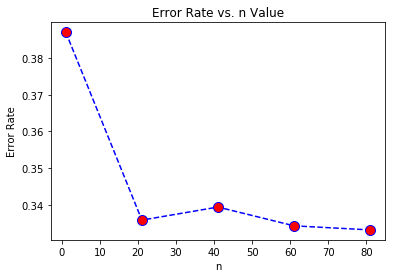

In [34]:
e=rf_error(100,X_train3,y_train3,X_test3,y_test3)

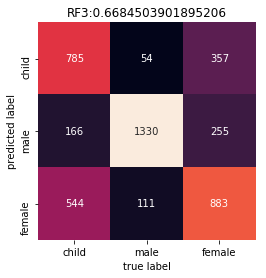

Accuracy=0.6684503901895206
              precision    recall  f1-score   support

       child     0.6564    0.5251    0.5834      1495
      female     0.7596    0.8896    0.8195      1495
        male     0.5741    0.5906    0.5823      1495

   micro avg     0.6685    0.6685    0.6685      4485
   macro avg     0.6633    0.6685    0.6617      4485
weighted avg     0.6633    0.6685    0.6617      4485



In [35]:
model=ensemble.RandomForestClassifier(n_estimators = e)
classify(model,X_train3,y_train3,X_test3,y_test3,desc="RF3")

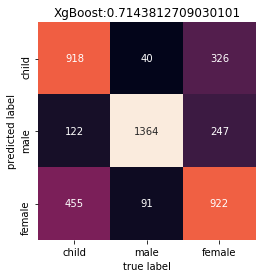

Accuracy=0.7143812709030101
              precision    recall  f1-score   support

       child     0.7150    0.6140    0.6607      1495
      female     0.7871    0.9124    0.8451      1495
        male     0.6281    0.6167    0.6223      1495

   micro avg     0.7144    0.7144    0.7144      4485
   macro avg     0.7100    0.7144    0.7094      4485
weighted avg     0.7100    0.7144    0.7094      4485



In [36]:
# XgBoost
model = xgboost.XGBClassifier()
classify(model,X_train,y_train,X_test,y_test,desc="XgBoost")

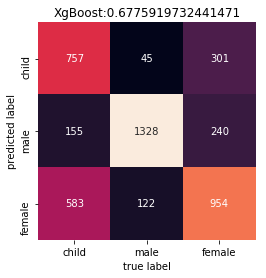

Accuracy=0.6775919732441471
              precision    recall  f1-score   support

       child     0.6863    0.5064    0.5828      1495
      female     0.7707    0.8883    0.8254      1495
        male     0.5750    0.6381    0.6049      1495

   micro avg     0.6776    0.6776    0.6776      4485
   macro avg     0.6774    0.6776    0.6710      4485
weighted avg     0.6774    0.6776    0.6710      4485



In [37]:
model = xgboost.XGBClassifier()
classify(model,X_train3,y_train3,X_test3,y_test3,desc="XgBoost")

In [38]:
# Support Vector Machine
def svm_kernel(x_train,y_train,x_test,y_test):
    rate=[]
    kernel=['rbf','poly','linear']
    for i in kernel:
        model=svm.SVC(kernel=i, gamma='scale').fit(x_train,y_train)
        y_pred=model.predict(x_train)
        print(i, ' in-sample accuracy in SVM: ', accuracy_score(y_train,y_pred))
        y_pred=model.predict(x_test)
        print(i, ' out-of-sample accuracy in SVM: ', accuracy_score(y_test,y_pred))
        rate.append(accuracy_score(y_test,y_pred))
    nloc = rate.index(max(rate))
    print("Highest accuracy is %s occurs at %s kernel." % (rate[nloc], kernel[nloc]))
    return kernel[nloc]

In [39]:
def svm_error(k,C,x_train,y_train,x_test,y_test):
    error_rate = []
    C=range(1,C)
    for i in C:
        model=svm.SVC(kernel=k,C=i, gamma='scale').fit(x_train,y_train)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    cloc = error_rate.index(min(error_rate))
    print("Lowest error is %s occurs at C=%s." % (error_rate[cloc], C[cloc]))

    plt.plot(C, error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. C Value')
    plt.xlabel('C')
    plt.ylabel('Error Rate')
    plt.show()
    return C[cloc]

In [40]:
k=svm_kernel(X_train,y_train,X_test,y_test)

rbf  in-sample accuracy in SVM:  0.7548598517387293
rbf  out-of-sample accuracy in SVM:  0.7221850613154961
poly  in-sample accuracy in SVM:  0.7616684165314498
poly  out-of-sample accuracy in SVM:  0.717948717948718
linear  in-sample accuracy in SVM:  0.7097769717794534
linear  out-of-sample accuracy in SVM:  0.6633221850613155
Highest accuracy is 0.7221850613154961 occurs at rbf kernel.


Lowest error is 0.27224080267558526 occurs at C=8.


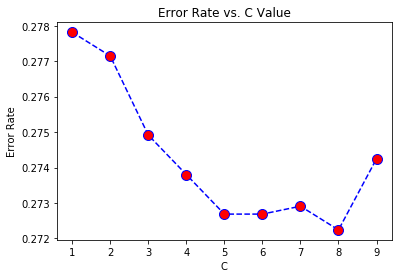

In [41]:
c=svm_error(k,10,X_train,y_train,X_test,y_test)

C:\Users\Max\Anaconda3\envs\torch\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


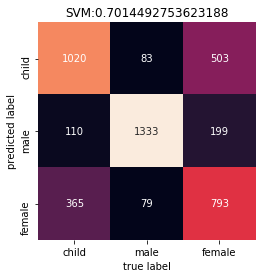

Accuracy=0.7014492753623188
              precision    recall  f1-score   support

       child     0.6351    0.6823    0.6579      1495
      female     0.8118    0.8916    0.8499      1495
        male     0.6411    0.5304    0.5805      1495

   micro avg     0.7014    0.7014    0.7014      4485
   macro avg     0.6960    0.7014    0.6961      4485
weighted avg     0.6960    0.7014    0.6961      4485



In [42]:
model=svm.SVC(kernel=k,C=c, gamma='scale')
classify(model,X_train,y_train,X_test,y_test, desc='SVM')

In [43]:
k=svm_kernel(X_train3,y_train3,X_test3,y_test3)

rbf  in-sample accuracy in SVM:  0.6903057491012058
rbf  out-of-sample accuracy in SVM:  0.6778149386845039
poly  in-sample accuracy in SVM:  0.6720117081861856
poly  out-of-sample accuracy in SVM:  0.6472686733556299
linear  in-sample accuracy in SVM:  0.6407050364290032
linear  out-of-sample accuracy in SVM:  0.6225195094760312
Highest accuracy is 0.6778149386845039 occurs at rbf kernel.


Lowest error is 0.3221850613154961 occurs at C=1.


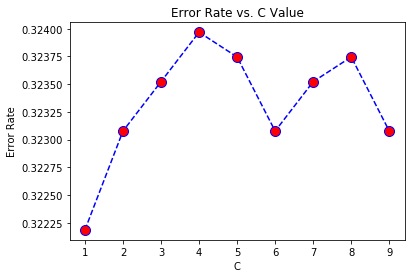

In [44]:
c=svm_error(k,10,X_train3,y_train3,X_test3,y_test3)

C:\Users\Max\Anaconda3\envs\torch\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


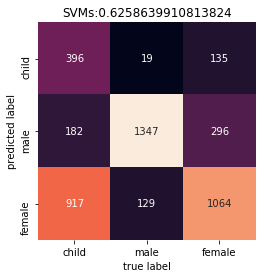

Accuracy=0.6258639910813824
              precision    recall  f1-score   support

       child     0.7200    0.2649    0.3873      1495
      female     0.7381    0.9010    0.8114      1495
        male     0.5043    0.7117    0.5903      1495

   micro avg     0.6259    0.6259    0.6259      4485
   macro avg     0.6541    0.6259    0.5963      4485
weighted avg     0.6541    0.6259    0.5963      4485



In [45]:
model=svm.SVC(kernel=k,C=c, gamma='scale')
classify(model,X_train3,y_train3,X_test3,y_test3, desc='SVMs')

In [46]:
# Neural Network
def nn_error(n,x_train,y_train,x_test,y_test):
    error_rate = []
    hidden_layer=range(1,n)
    for i in hidden_layer:
        model = neural_network.MLPClassifier(solver='adam', alpha=1e-5,
                                       hidden_layer_sizes=i,
                                       activation='logistic',random_state=17,
                                       max_iter=2000)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    kloc = error_rate.index(min(error_rate))
    print("Lowest error is %s occurs at C=%s." % (error_rate[kloc], hidden_layer[kloc]))

    plt.plot(hidden_layer, error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. Hidden Layer Size')
    plt.xlabel('Size')
    plt.ylabel('Error Rate')
    plt.show()
    return hidden_layer[kloc]

Lowest error is 0.28762541806020064 occurs at C=14.


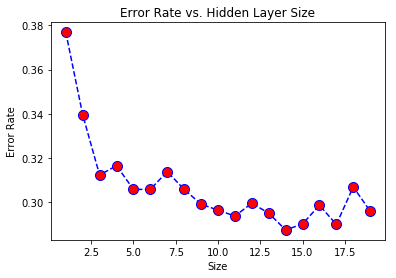

In [47]:
h=nn_error(20,X_train,y_train,X_test,y_test)

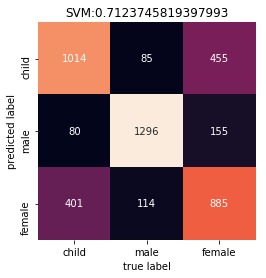

Accuracy=0.7123745819397993
              precision    recall  f1-score   support

       child     0.6525    0.6783    0.6651      1495
      female     0.8465    0.8669    0.8566      1495
        male     0.6321    0.5920    0.6114      1495

   micro avg     0.7124    0.7124    0.7124      4485
   macro avg     0.7104    0.7124    0.7110      4485
weighted avg     0.7104    0.7124    0.7110      4485



In [48]:
model = neural_network.MLPClassifier(solver='adam', alpha=1e-5,
                                       hidden_layer_sizes=h,
                                       activation='logistic',random_state=17,
                                       max_iter=2000)
classify(model,X_train,y_train,X_test,y_test, desc='SVM')

Lowest error is 0.3333333333333333 occurs at C=11.


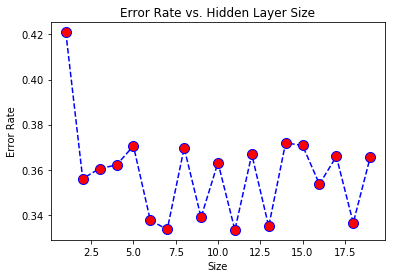

In [49]:
h=nn_error(20,X_train3,y_train3,X_test3,y_test3)

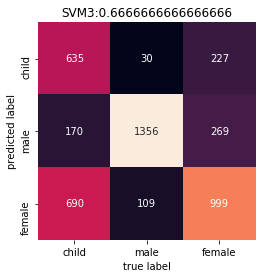

Accuracy=0.6666666666666666
              precision    recall  f1-score   support

       child     0.7119    0.4247    0.5320      1495
      female     0.7554    0.9070    0.8243      1495
        male     0.5556    0.6682    0.6067      1495

   micro avg     0.6667    0.6667    0.6667      4485
   macro avg     0.6743    0.6667    0.6544      4485
weighted avg     0.6743    0.6667    0.6544      4485



In [50]:
model = neural_network.MLPClassifier(solver='adam', alpha=1e-5,
                                       hidden_layer_sizes=h,
                                       activation='logistic',random_state=17,
                                       max_iter=2000)
classify(model,X_train3,y_train3,X_test3,y_test3, desc='SVM3')